In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from imblearn.over_sampling import SMOTENC

#### Goal: Predict if a patience will be readmitted

### $Diabetic$ $Data$

In [2]:
# Read the data
df = pd.read_csv("diabetic_data.csv")

**We explore the data to see what we have**

In [3]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


**There are "?" values in some columns (e.g. weight), we will change them to nan values to count them for any column.**

In [4]:
df.replace("?", np.nan, inplace=True)

In [5]:
print("we have", df.shape[0], "rows and", df.shape[1], "columns.")

we have 101766 rows and 50 columns.


#### Check for duplicated data

In [6]:
print("We have no duplicated entries")
df[df.duplicated()]

We have no duplicated entries


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted


#### But we have duplicated patients

In [7]:
print("we have",df[df.duplicated(subset=["patient_nbr"])].shape[0], "duplicated entries for patiences")

we have 30248 duplicated entries for patiences


**IMPORTANT NOTE. Here I had my first problem that I would like to discuss, Strack et al in this paper https://www.hindawi.com/journals/bmri/2014/781670/ take just one observation per patience, doing this there is an improvement with the prediction. But, I think that this approach has a bias because misses some valuable information about the real prediction power of the number of services that a patience have in a previous year (I would like to discuss this)**

In [8]:
#df = df.drop_duplicates(subset= ['patient_nbr'], keep = 'first') #to discuss 

In [9]:
print("Type of all of the columns")
df.dtypes

Type of all of the columns


encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

**the detailed description of data could be found in https://www.hindawi.com/journals/bmri/2014/781670/tab1**

**A lot of columns are objects (i.e. they are considered as strings), so we will have to deal with this in subsequent steps**

**check the percentage of the nan values**

In [10]:
print("Percentage of nan values for any column")
df.isnull().sum()/df.shape[0]*100 

Percentage of nan values for any column


encounter_id                 0.000000
patient_nbr                  0.000000
race                         2.233555
gender                       0.000000
age                          0.000000
weight                      96.858479
admission_type_id            0.000000
discharge_disposition_id     0.000000
admission_source_id          0.000000
time_in_hospital             0.000000
payer_code                  39.557416
medical_specialty           49.082208
num_lab_procedures           0.000000
num_procedures               0.000000
num_medications              0.000000
number_outpatient            0.000000
number_emergency             0.000000
number_inpatient             0.000000
diag_1                       0.020636
diag_2                       0.351787
diag_3                       1.398306
number_diagnoses             0.000000
max_glu_serum                0.000000
A1Cresult                    0.000000
metformin                    0.000000
repaglinide                  0.000000
nateglinide 

**Most of the columns are ok, but there some of them that have a lot of nan values (weight, payer_code and medical_specialty)** 

In [11]:
# drop columns with a lot of nan values
df = df.drop(["weight", "payer_code", "medical_specialty"], axis=1)

In [12]:
## A function to draw multiple hists in a grid

def showhists(df, variables, nrows, ncols, size):
    fig=plt.figure(figsize=size)
    for i, col in enumerate(variables):
        ax=fig.add_subplot(nrows,ncols,i+1)
        df[col].hist(ax=ax)
        ax.set_title(col)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

**Now we will make an analysis for any column that we have**

Count the different label for readmitted's column


<AxesSubplot:>

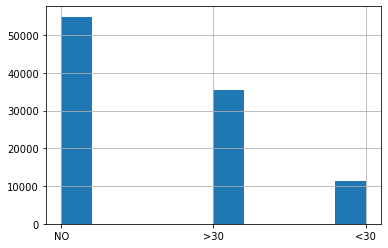

In [13]:
print("Count the different label for readmitted's column") 
df.readmitted.hist()

**IMPORTANT NOTE (I would like to discuss this part)** 

**As you can see the data is imbalanced, that is, there is one label with a lot of observations but the other two labels have considerably fewer observations. This is a problem because almost all of the good classification models could prioritize classify the observations with the label with more counts, this is not desirable.**

**Possible solutions for this would be training One vs All for our classifier and after that using imbalance ratio as a parameter, or creating artificial observations. The reason of this, are the following:** 
* **With just two classes we could use imbalanced ratio as a parameter in order to increase the penalization error when the the classifier fail to predict the label with fewer observations.**

* **Using SMOTENC function to artificially create variables for the undersample population fixes (or try to fix) the imbalanced problem.**

In [14]:
# Transform the y (readmitted) variable in a dummy variable
catdict = {"NO":0, "<30":1,">30":0}
df.readmitted = df.readmitted.map(catdict)

Count the different label for some columns


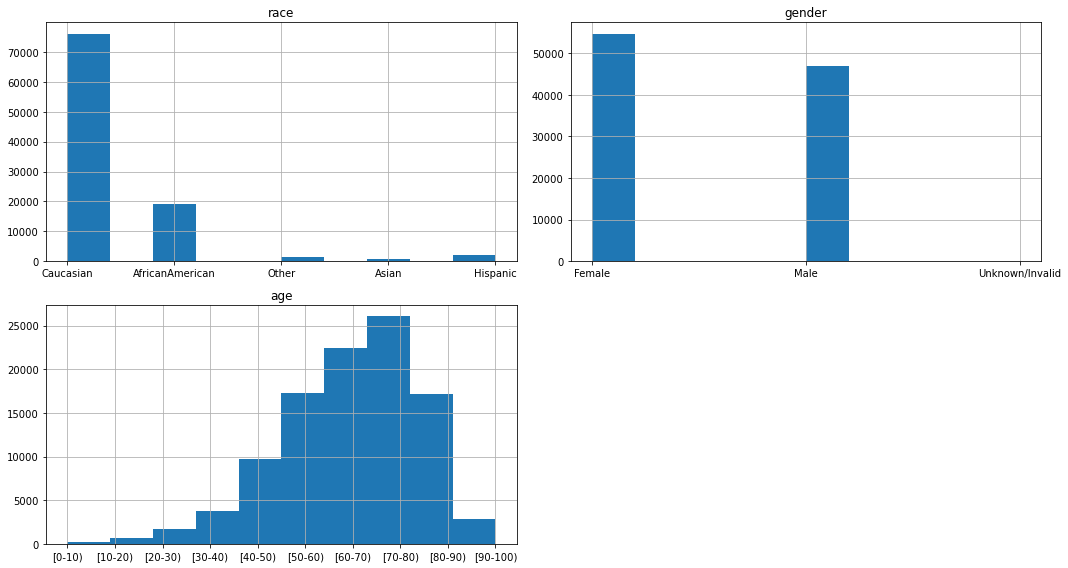

In [15]:
print("Count the different label for some columns")
showhists(df[["race", "gender", "age"]], df[["race", "gender", "age"]].columns, 2, 2, (15,8))

**Here we have have to notice the following:**

* **We have a very small number of observations for some races (Hispanic, Asian and Other), this could be a problem for two reasons:**
    1. **If we used linear models, the parameter that measures the impact of these labels could be not stastistically significant.**
    2. **Representation (or maybe selection) bias, this is, imagine that because we have just a few of observations of Asian people in our observations, they could be not representative of the population of the Asian people.**
    
    
* **We have a very small number of invalid gender, we could just drop these observations.**

In [16]:
# Solve the two problems
df["race"] = np.where(df.race.isin(["Asian","Hispanic"]), "Other", df.race)
df = df[df.gender!="Unknown/Invalid"]
df=df.dropna(how="any", axis =0)

#### We will transform the age variable in 3 categories:
* **patiences that are younger than 30 years old.**
* **between 30-60 years old.**
* **older than 60 years old.** 

In [17]:
agedict={"[0-10)":"age_less_30", "[10-20)":"age_less_30", "[20-30)":"age_less_30",
       "[30-40)":"age_30_60", "[40-50)":"age_30_60", "[50-60)":"age_30_60",
       "[60-70)":"age_more_60", "[70-80)":"age_more_60", "[80-90)":"age_more_60", "[90-100)":"age_more_60"}

df.age=df.age.map(agedict)

#### Now visualize the number of readmitted patiences grouped by gender, race and age

/home/cosmicfox/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Gender VS Readmitted')

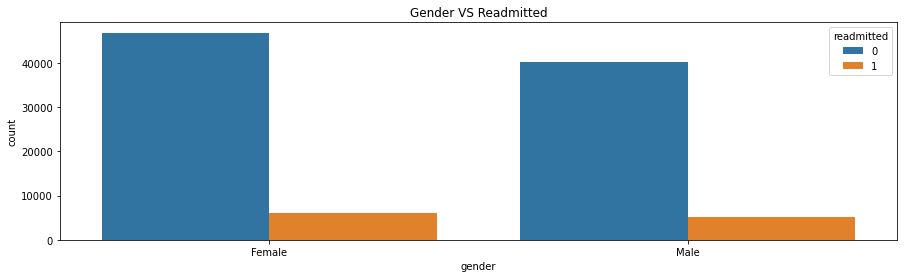

In [18]:
fig = plt.figure(figsize=(15,4))
sns.countplot(df['gender'], hue = df['readmitted']).set_title("Gender VS Readmitted")

/home/cosmicfox/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Race VS Readmitted')

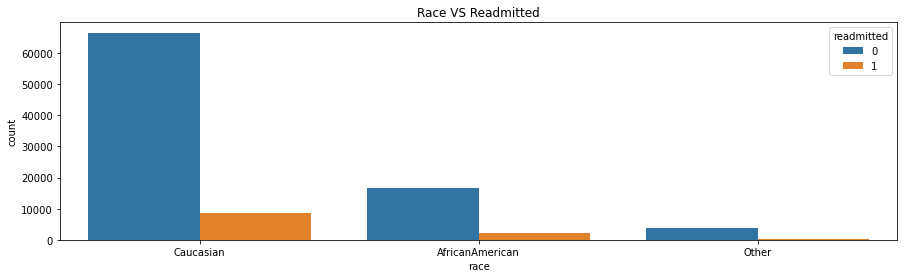

In [19]:
fig = plt.figure(figsize=(15,4))
sns.countplot(df['race'], hue = df['readmitted']).set_title("Race VS Readmitted")

/home/cosmicfox/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Age VS Readmitted')

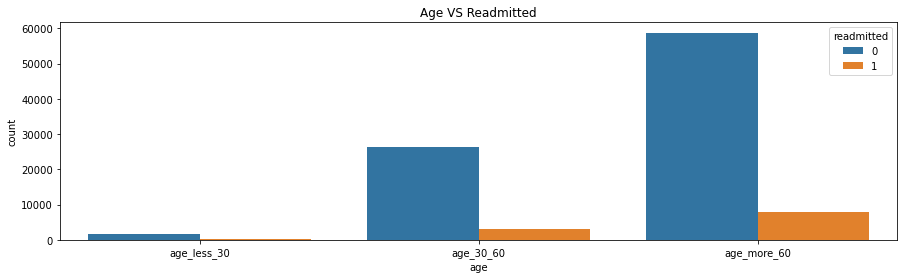

In [20]:
fig = plt.figure(figsize=(15,4))
sns.countplot(df['age'], hue = df['readmitted']).set_title("Age VS Readmitted")

**Keep with the data treatment.**

In [21]:
print("Count the different label for some diagnosis columns")
for col in ['diag_1', 'diag_2', 'diag_3']:
    print("-------------------------------------")
    print("-------------------------------------")
    print(col)
    print(df[col].value_counts())

Count the different label for some diagnosis columns
-------------------------------------
-------------------------------------
diag_1
428    6730
414    6373
786    3900
410    3514
486    3412
       ... 
906       1
817       1
690       1
700       1
915       1
Name: diag_1, Length: 713, dtype: int64
-------------------------------------
-------------------------------------
diag_2
428     6517
276     6513
250     5412
427     4919
401     3613
        ... 
V13        1
846        1
E868       1
V60        1
182        1
Name: diag_2, Length: 740, dtype: int64
-------------------------------------
-------------------------------------
diag_3
250    11208
401     8089
276     5097
428     4491
427     3865
       ...  
475        1
875        1
876        1
57         1
236        1
Name: diag_3, Length: 786, dtype: int64


**The main problem with Diagnosis variables is that there are a lot of classes, but fortunalety we could reduce the number of classes using the classification from https://icd.codes/icd9cm**

In [22]:
print("Count the different label for diagnosis columns")

# Solution of the problem with many classes for diagbosis 
for col in ['diag_1', 'diag_2', 'diag_3']:
    df[col] = np.where(df[col].str.contains("V"), 10000, df[col])
    df[col] = np.where(df[col].str.contains("E"), 20000, df[col])
    df[col] = np.float64(df[col]).astype(int)

desc = {10000: "other", 20000:"other"}
for i in range(1, 1000):
    if i <= 139:
        desc[ i] = "infectiousAndParasit"
    elif i >= 140 and i <= 239:
        desc[ i] = "neoplasms"
    elif i >= 240 and i <= 279:
        desc[ i] = "endocrine"
    elif i >= 280 and i <= 289:
        desc[ i] = "blood"
    elif i >= 290 and i <= 319:
        desc[ i] = "mental"
    elif i >= 320 and i <= 389:
        desc[ i] = "nervous"
    elif i >= 390 and i <= 459:
        desc[ i] = "circulatory"
    elif i >= 460 and i <= 519:
        desc[ i] = "respiratory"
    elif i >= 520 and i <= 579:
        desc[ i] = "digestive"
    elif i >= 580 and i <= 629:
        desc[ i] = "geniourinary"
    elif i >= 630 and i <= 679:
        desc[ i] = "pregnancy"
    elif i >= 680 and i <= 709:
        desc[ i] = "skin"
    elif i >= 710 and i <= 739:
        desc[ i] = "muculoskeletal"
    elif i >= 740 and i <= 759:
        desc[ i] = "congenital"
    elif i >= 760 and i <= 779:
        desc[ i] = "perinatal"
    elif i >= 780 and i <= 799:
        desc[ i] = "syptoms"
    elif i >= 800 and i <= 999:
        desc[ i] = "injury"

df.diag_1 = df.diag_1.map(desc)
df.diag_2 = df.diag_2.map(desc)
df.diag_3 = df.diag_3.map(desc)

Count the different label for diagnosis columns


In [23]:
print("Count the different label for some diagnosis columns")
for col in ['diag_1', 'diag_2', 'diag_3']:
    print("-------------------------------------")
    print("-------------------------------------")
    print(col)
    print(df[col].value_counts())

Count the different label for some diagnosis columns
-------------------------------------
-------------------------------------
diag_1
circulatory             29529
endocrine               10557
respiratory             10093
digestive                8928
syptoms                  7427
injury                   6703
geniourinary             4947
muculoskeletal           4739
neoplasms                3312
infectiousAndParasit     2689
skin                     2438
mental                   2145
other                    1601
nervous                  1170
blood                    1079
pregnancy                 645
congenital                 50
Name: diag_1, dtype: int64
-------------------------------------
-------------------------------------
diag_2
circulatory             30602
endocrine               19796
respiratory             10006
geniourinary             7829
syptoms                  4492
digestive                3850
skin                     3472
blood                    2848
ment

#### Check the count for some tests 

Count the different label for some columns


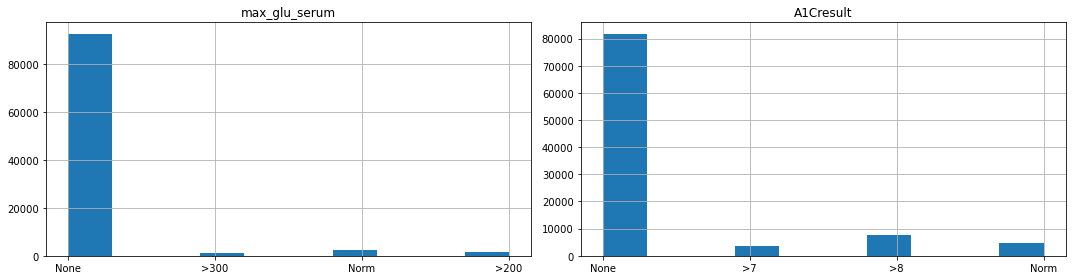

In [24]:
print("Count the different label for some columns")
showhists(df[['max_glu_serum', 'A1Cresult']], df[['max_glu_serum', 'A1Cresult']].columns, 1, 2, (15,4))

**The problem that I see here is that we have a lot of patience with no test registered, even so I will keep these variables without any change because I think that they are important (at least glucose measurement is important for diabetic patiences as I know).**

**Check the count for some doses medications variables**

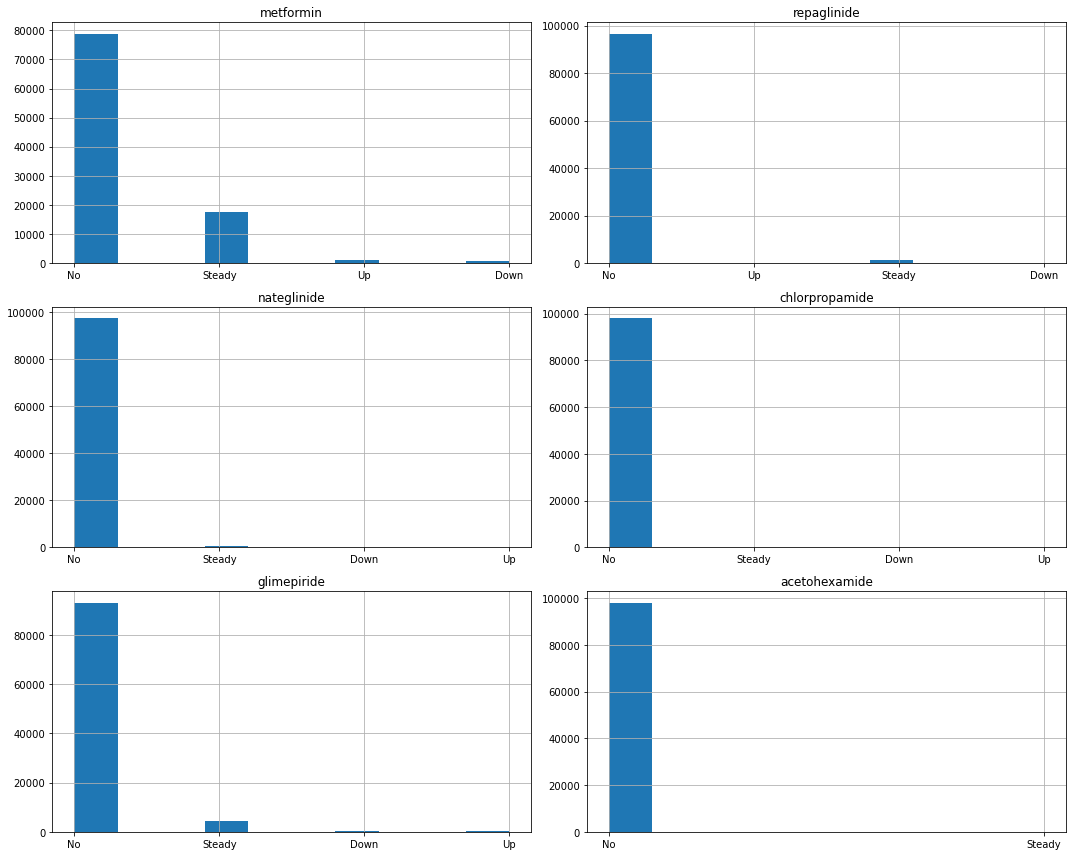

In [25]:
medcols = ['metformin', 'repaglinide', 'nateglinide','chlorpropamide', 'glimepiride', 'acetohexamide']
showhists(df[medcols], df[medcols].columns, 3, 2, (15,12))

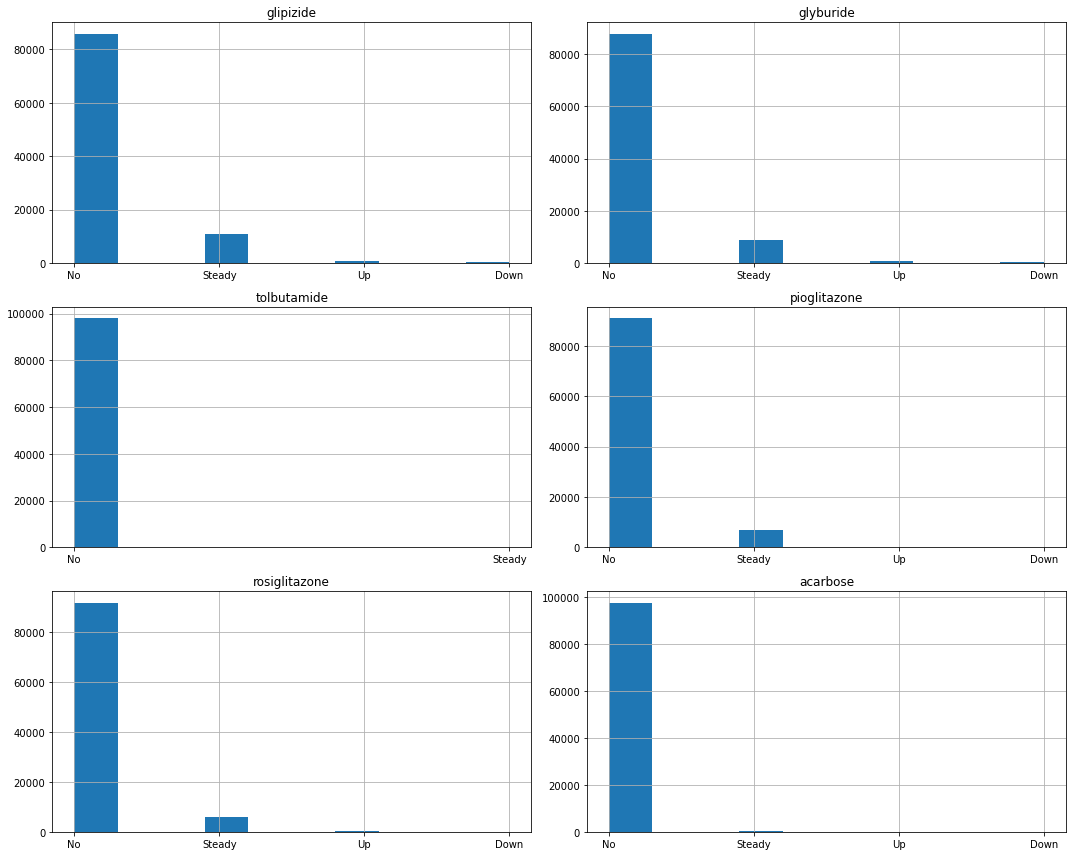

In [26]:
medcols = ['glipizide','glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone','acarbose']

showhists(df[medcols], df[medcols].columns, 3, 2, (15,12))

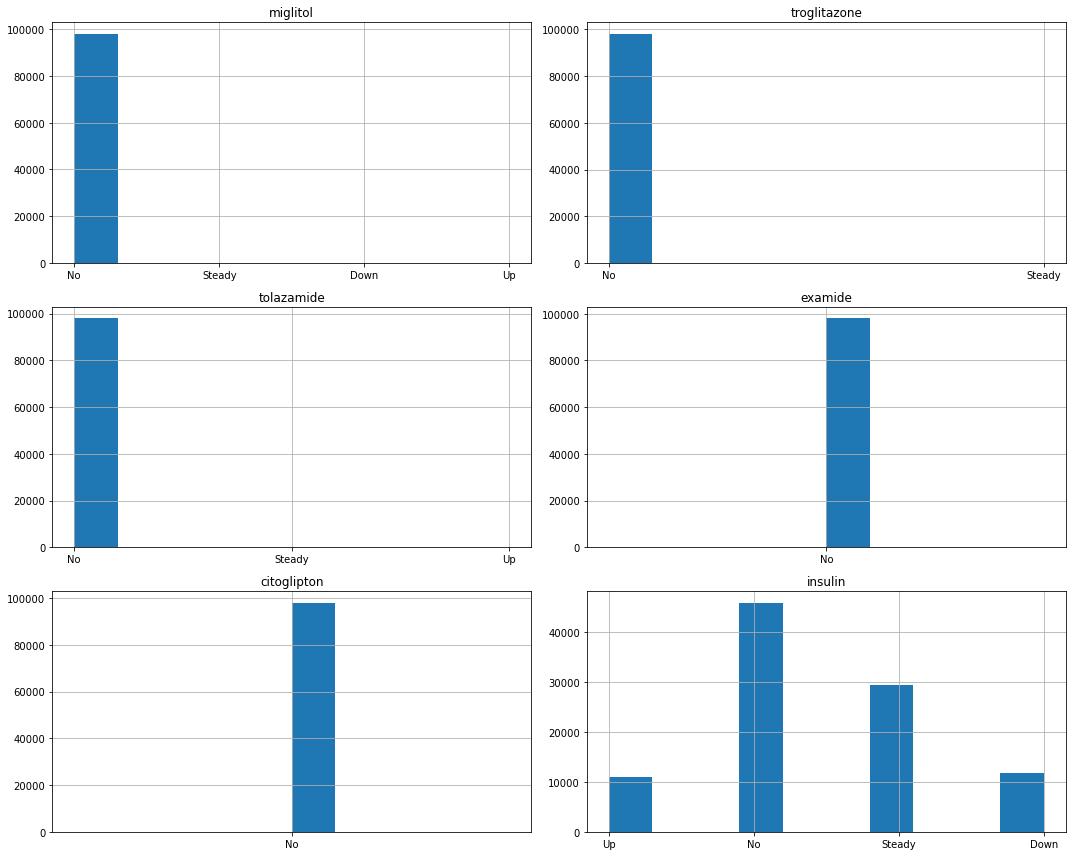

In [27]:
medcols = ['miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton','insulin']

showhists(df[medcols], df[medcols].columns, 3, 2, (15,12))

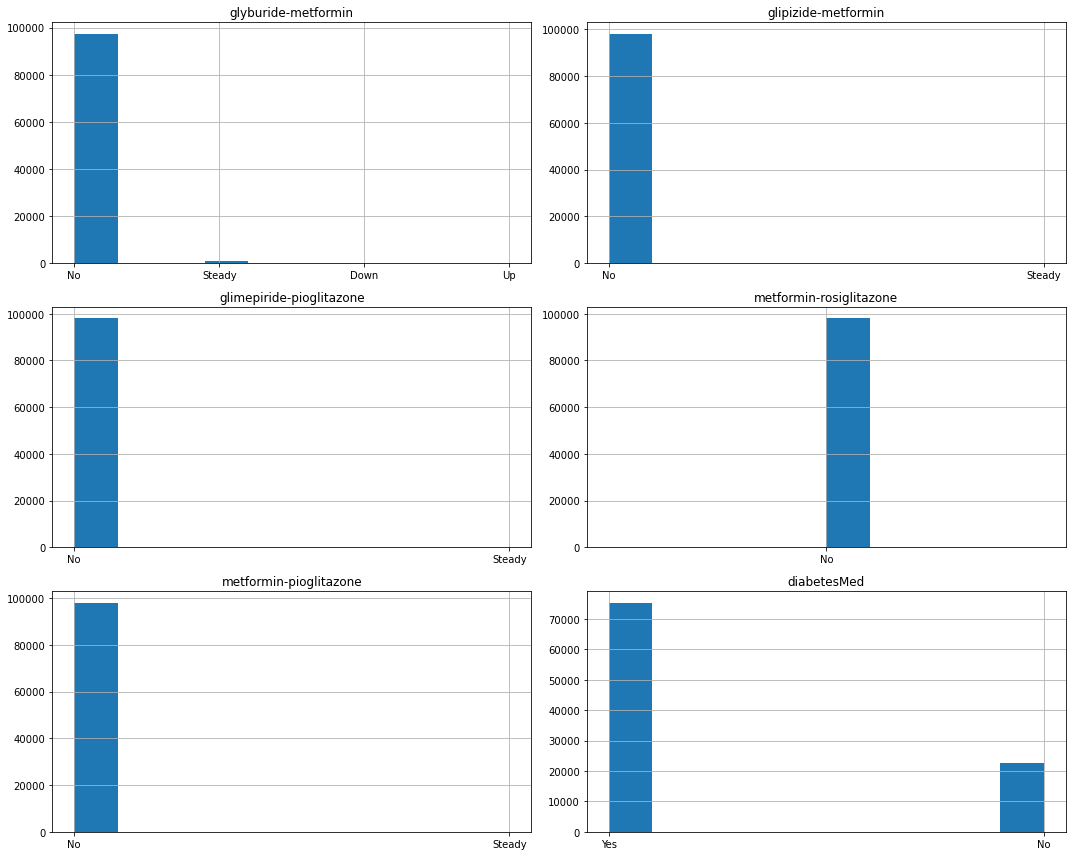

In [28]:
medcols = ['glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone', 'metformin-rosiglitazone',
           'metformin-pioglitazone','diabetesMed']

showhists(df[medcols], df[medcols].columns, 3, 2, (15,12))

**The Problem Here is that we have some variables with just one kind of label as citoglipton, and other ones with labels with a very small number of observations as metformin-rosiglitazone. We will drop these columns**

In [29]:
df = df.drop(['metformin-rosiglitazone','metformin-pioglitazone','glimepiride-pioglitazone',
             'citoglipton','examide','troglitazone', 'acetohexamide'], axis=1)

**Check for the count in change in medications**

<AxesSubplot:>

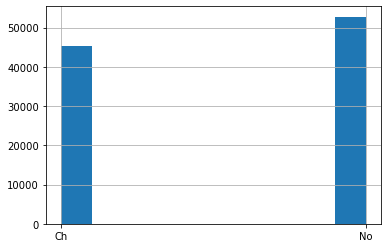

In [30]:
df.change.hist()

**We have no problem with Change Observations**

In [31]:
# Transform in dummy variables some columns
chdict = {"Ch":1, "No":0}
diabmdict = {"Yes":1, "No":0}
genddict = {"Female":1, "Male":0}
df.change =df.change.map(chdict)
df.diabetesMed = df.diabetesMed.map(diabmdict)
df.gender = df.gender.map(genddict)

#### Check the count for services in previous year and also other historical data for patiences.

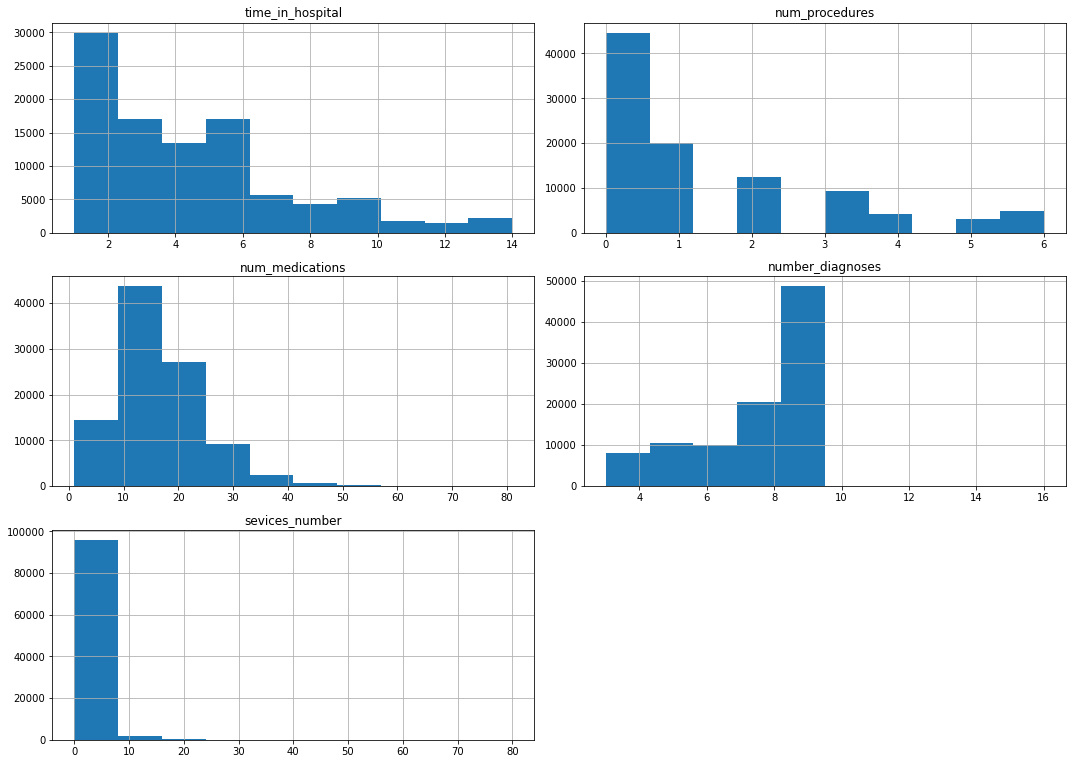

In [32]:
df['sevices_number'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']

cols = ['time_in_hospital', 'num_procedures','num_medications', 'number_diagnoses', 'sevices_number']

showhists(df[cols], df[cols].columns, 4, 2, (15,14))

#### The Problem with services_number, num_medications and number_diagnoses is that they have outliers but at this moment I do not feel comfortable truncating these variables, even using some good criteria as MAD.

### Transformations of the columns

In [33]:
# Our categorical X's columns should be transform using one hot encoding
mylist = []

for col in ['race', 'age', 'max_glu_serum','A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 
            'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide','tolbutamide', 'pioglitazone', 
            'rosiglitazone', 'acarbose','miglitol','tolazamide', 'insulin', 'glyburide-metformin', 
            'glipizide-metformin','diag_1','diag_2','diag_3']:
    df[col] = col + "_" + df[col]
    newdf = pd.get_dummies(df[col], dtype=np.int64)
    mylist.append(newdf)

catdf = pd.concat(mylist, axis=1)
cols = catdf.columns.to_list()

In [34]:
# Add numerical and dummy variables
df = pd.concat([df, catdf], axis = 1)
cols.extend(['time_in_hospital', 'num_procedures','num_medications', 'sevices_number',
             'number_diagnoses','readmitted', "change", 'diabetesMed', 'gender'])
df = df[cols]

### Now We are already to modeling

**For time reasons, we will not do cross validation on the model parameters. But this is very important, don't forget that.**

In [35]:
# Index of categorical variables
myindex=[]
for i in range(df.drop(['readmitted'], axis=1).columns.shape[0]):
    if df.columns[i] != 'readmitted':
        if df[df.columns[i]].unique().shape[0]==2:
            myindex.append(i)

# X, y variables
y = np.asanyarray(df["readmitted"])
X = np.asanyarray(df.drop("readmitted", axis=1))

# As the data is umbalanced we will create more data for patiences that were readmitted
# smotenc allows us to create more observations when we have X categorical variables
smt = SMOTENC(categorical_features=myindex, random_state=0)
X, y = smt.fit_sample(X, y)

# 5-Cross Validation for Lightgbm
kf = KFold(n_splits=5, shuffle=True)
results=[]

count = 1
for train_index, test_index in kf.split(X):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    gbm = lgb.LGBMClassifier(objective='binary',
                             num_leaves=60,
                             lambda_1=1,
                             learning_rate=.1,
                             n_estimators=200)
    
    print("Validation...", count)
    count+=1
    
    gbm.fit(X_train, y_train, eval_metric='entropy')
    y_hat = y_hat = gbm.predict(X_test)
    results.append(accuracy_score(y_test, y_hat))

Validation... 1
Validation... 2
Validation... 3
Validation... 4
Validation... 5


#### Accuracy

In [36]:
print("Accuracy of the model is", np.mean(results)*100, "%")

Accuracy of the model is 93.23684240501336 %


#### Confusion Matrix

In [37]:
dmc = pd.DataFrame(y_test, columns=['y_test'])
dmc["y_hat"]=y_hat

confusion_matrix = pd.crosstab(dmc['y_test'], dmc['y_hat'], rownames=['Real'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1
Real,,
0,17340,25
1,2334,15095


#### Feature Importance

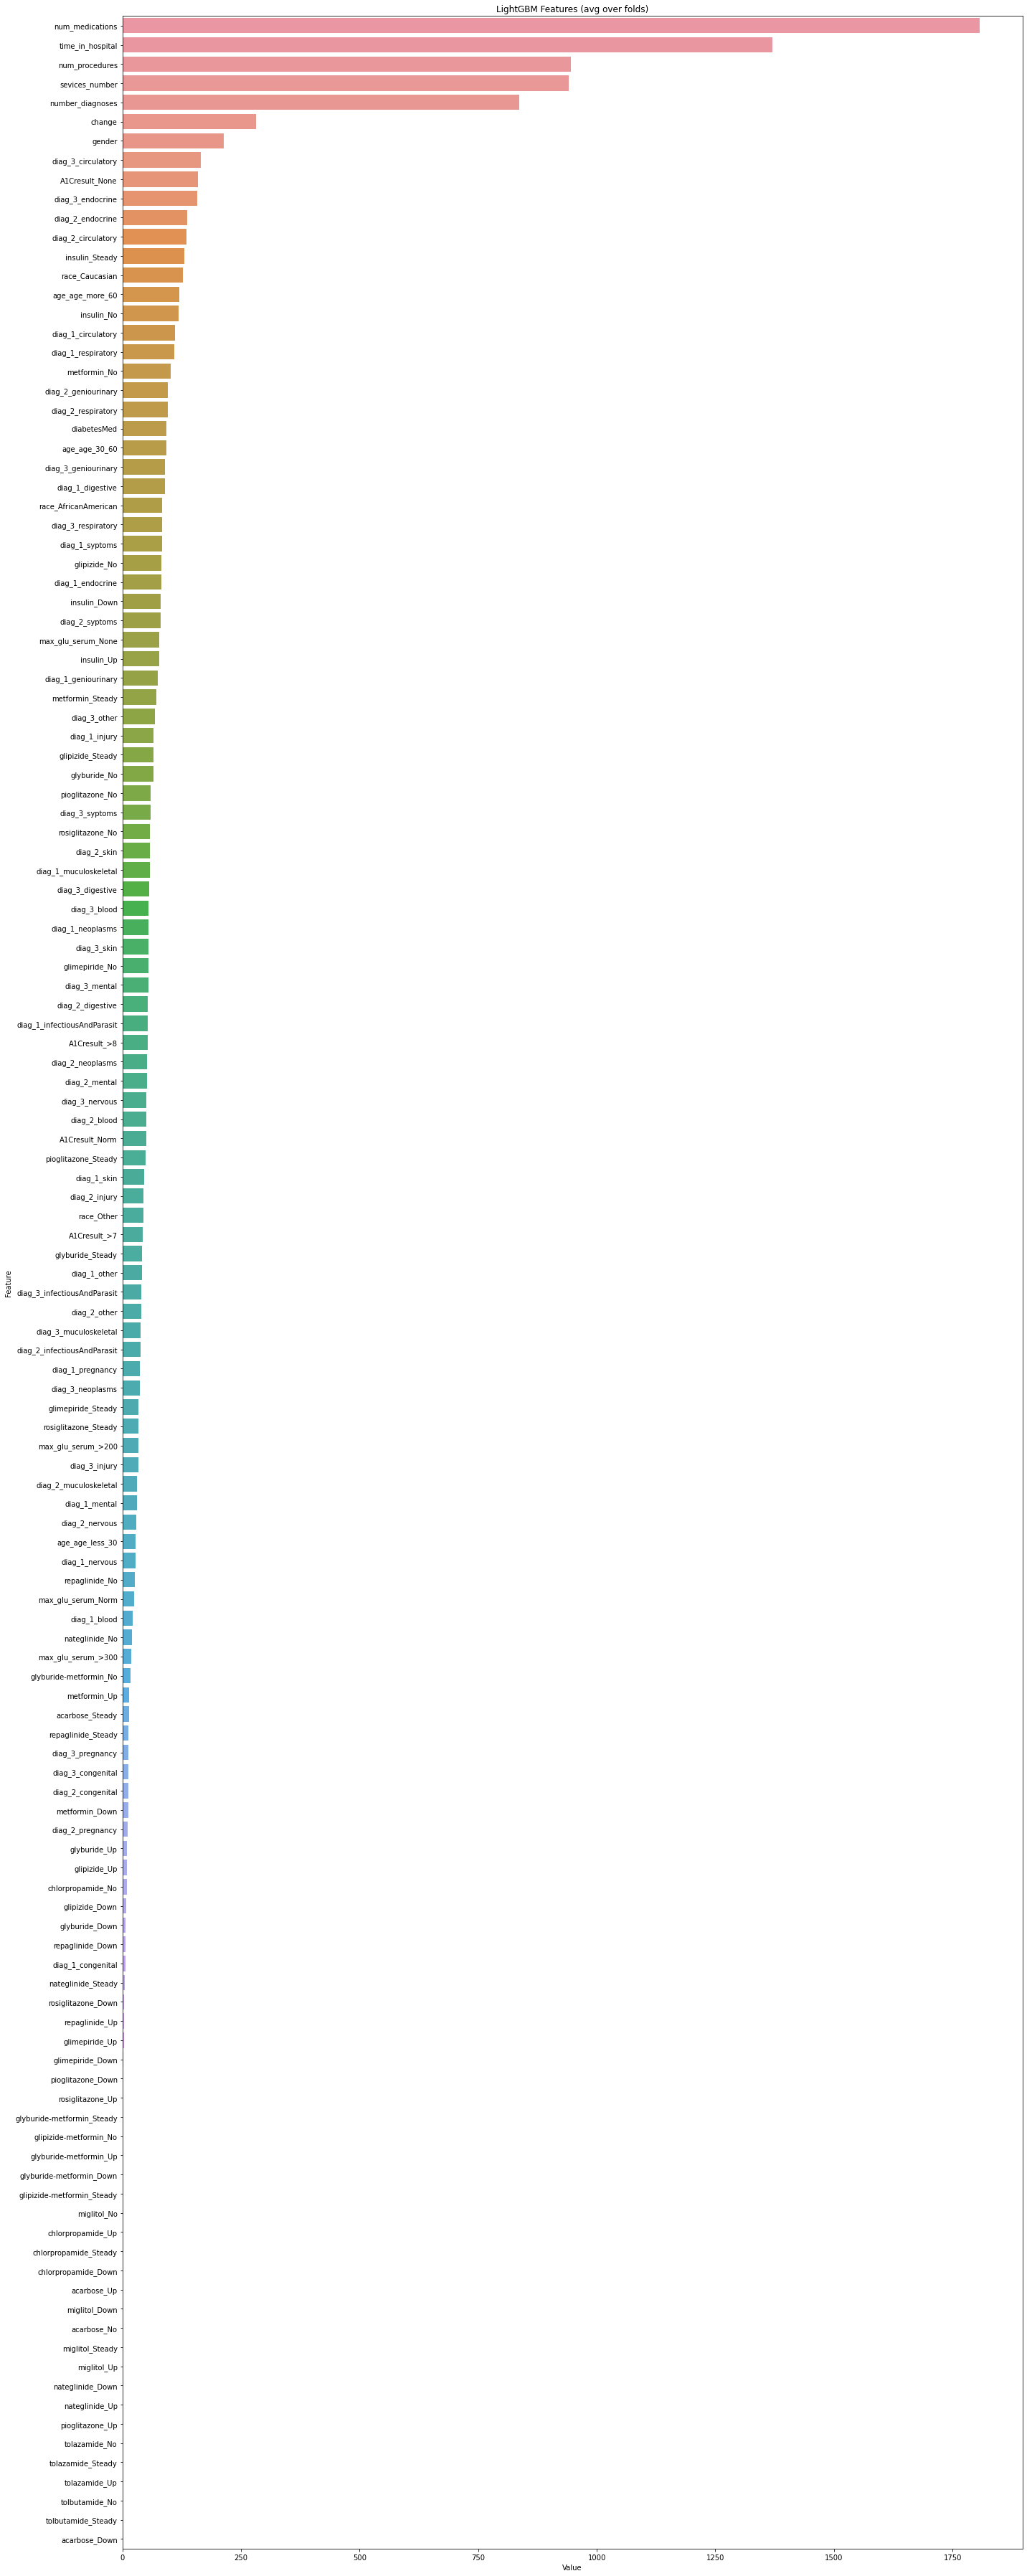

In [38]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importances_,df.drop("readmitted", axis=1).columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 50))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
